# Virtual Network Embedding: Hybrid (Quantum-Classical) Solution

- By Yasaman Parhizkar

- University of Tehran - July 2022 / Tir 1401
***

&#9635; Virtual Network Embedding (VNE) problem is essentially the mapping of one (directed and weighted) graph to another, such that weights of nodes and edges of the first graph are less equal to that of the second.
More detailed and clear explanation of the problem can be found in [[1]](#ref1)

This notebook proposes a solution for VNE which simulates the usage of a quantum computer to solve a part of it. Simulations are done using __[IBM's Qiskit framework](https://qiskit.org/)__. 
This notebook breaks VNE into two sub-problems: node-mapping and link-mapping.
For node-mapping, three different classical approaches are used.
For link-mapping, an optimization problem is formed to describe optimal link-mapping; then, that optimization problem is solved using a quantum computing alogorithm called Variational Quantum Eigensolver (VQE).


In this notebook, first we create two random directed and weighted graphs, then map one of them to the other while adhering to the VNE constraints.
If a valid mapping is possible, the algorithm returns that mapping. If such a mapping is impossible or is not found by the algorithm, it returns *False* to indicate failure.

<a id="ref1"></a>
###### [1] A. Fischer et. al, "Virtual Network Embedding: A Survey," in IEEE Communications Surveys & Tutorials

## Load packages

In [1]:
# Load required packages
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

# Cplex package for classical optimization
try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")

# Qiskit packages
from qiskit import BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

## Problem Setup

This section randomly creates two directed graphs with weighted edges and nodes; one of them is called the Substrate Network (SN) and the other is Virtual Network (VN).

In [2]:
# Setup subtrate and virtual networks
class Initializer():

    def __init__(self, sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
                vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc):
        
        self.sn_min_Vs = sn_min_Vs
        self.sn_max_Vs = sn_max_Vs
        self.sn_min_cc = sn_min_cc
        self.sn_max_cc = sn_max_cc
        self.sn_min_bc = sn_min_bc
        self.sn_max_bc = sn_max_bc
        
        self.vn_min_Vs = vn_min_Vs
        self.vn_max_Vs = vn_max_Vs
        self.vn_min_cc = vn_min_cc
        self.vn_max_cc = vn_max_cc
        self.vn_min_bc = vn_min_bc
        self.vn_max_bc = vn_max_bc
        
    def generate_problem(self):
        
        sn_min_Vs = self.sn_min_Vs
        sn_max_Vs = self.sn_max_Vs
        sn_min_cc = self.sn_min_cc
        sn_max_cc = self.sn_max_cc
        sn_min_bc = self.sn_min_bc
        sn_max_bc = self.sn_max_bc
        
        vn_min_Vs = self.vn_min_Vs
        vn_max_Vs = self.vn_max_Vs
        vn_min_cc = self.vn_min_cc
        vn_max_cc = self.vn_max_cc
        vn_min_bc = self.vn_min_bc
        vn_max_bc = self.vn_max_bc
        
        n = np.random.randint(low = sn_min_Vs, high = sn_max_Vs + 1)
        m = np.random.randint(low = vn_min_Vs, high = min(n, vn_max_Vs) + 1)
        
        SN = self.generate_random_graph(n, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc)
        VN = self.generate_random_graph(m, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc)
        
        return (SN, VN)
        
    def generate_random_graph(self, n, min_cc, max_cc, min_bc, max_bc):
        
        V = [i for i in range(n)]
        E = [(i, j) for i in V for j in V if i < j and np.random.randint(0,2) == 1]
        E.extend([(j, i) for (i, j) in E])
        T = {i: np.random.randint(min_cc, max_cc+1) for i in V}
        D = {(i, j): np.random.randint(min_bc, max_bc+1) for (i, j) in E if i < j}
        D.update({(j, i): D[i, j] for (i, j) in D})
        
        return (V, E, T, D)

    def generate_instance(self, n, D):

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii+1, n):
                if (ii, jj) in D:
                    instance[ii, jj] = D[ii, jj]
                    instance[jj, ii] = D[jj, ii]

        return xc, yc, instance
    
    def visualize_graph(self, xc, yc, instance, B, n, title_str, show_weights = True):
        
        plt.figure()
        plt.scatter(xc, yc, s=200)
        for i in range(len(xc)):
            plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
            
            if show_weights:
                plt.annotate(B[i], (xc[i] + 0.15, yc[i] - 0.45), size=16, color='g')

        plt.grid()

        for ii in range(n):
            for jj in range(ii+1, n):
                if instance[ii][jj]>0:
                    plt.plot([xc[ii], xc[jj]], [yc[ii], yc[jj]], linewidth=2)
                    if show_weights:
                        plt.annotate(int(instance[ii, jj]), (0.5*(xc[ii] + xc[jj]), 0.5*(yc[ii] + yc[jj])), size=16, color='b')

        plt.title(title_str)
        plt.show()

n = 4, m = 3

Subtrate network:
V0 = [0, 1, 2, 3]
E0 = [(0, 1), (1, 2), (1, 3), (2, 3), (1, 0), (2, 1), (3, 1), (3, 2)]
B = {0: 11, 1: 12, 2: 9, 3: 8}
K = {(0, 1): 6, (1, 2): 10, (1, 3): 14, (2, 3): 11, (1, 0): 6, (2, 1): 10, (3, 1): 14, (3, 2): 11}
instance_sn = 
[[ 0.  6.  0.  0.]
 [ 6.  0. 10. 14.]
 [ 0. 10.  0. 11.]
 [ 0. 14. 11.  0.]]

***

Virtual network:
V1 = [0, 1, 2]
E1 = [(0, 2), (2, 0)]
T1 = {0: 9, 1: 6, 2: 3}
D1 = {(0, 2): 9, (2, 0): 9}
instance_vn = 
[[0. 0. 9.]
 [0. 0. 0.]
 [9. 0. 0.]]


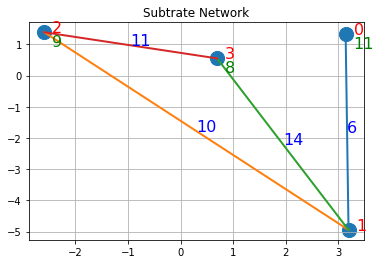

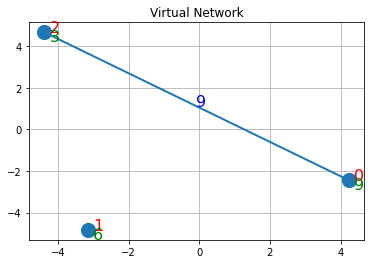

In [3]:
# Initialize the problem by defining the parameters
sn_min_Vs = 3
sn_max_Vs = 4
sn_min_cc = 8
sn_max_cc = 14
sn_min_bc = 5
sn_max_bc = 15

vn_min_Vs = 3
vn_max_Vs = 4
vn_min_cc = 1
vn_max_cc = 10
vn_min_bc = 1
vn_max_bc = 10

np.random.seed(45)

# Construct the graphs of the problem
initializer = Initializer(sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
                         vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc)
(SN, VN) = initializer.generate_problem()
n = len(SN[0])
m = len(VN[0])
xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

print("n = " + str(n) + ", m = " + str(m) + "\n")

# Show substrate network
print("Subtrate network:")
print("V0 = " + str(SN[0]))
print("E0 = " + str(SN[1]))
print("B = " + str(SN[2]))
print("K = " + str(SN[3]))
print("instance_sn = \n"+str(instance_sn))
print("\n***\n")

# Show virtual network
print("Virtual network:")
print("V1 = " + str(VN[0]))
print("E1 = " + str(VN[1]))
print("T1 = " + str(VN[2]))
print("D1 = " + str(VN[3]))
print("instance_vn = \n"+str(instance_vn))

initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")

* Manual alterations for testing:


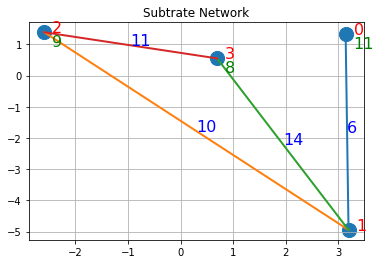

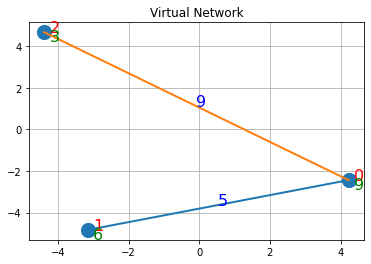

In [4]:
# manual SN and VN alterations for testing
instance_vn[0][1] = 5
instance_vn[1][0] = 5
VN[1].append((0,1))
VN[1].append((1,0))
VN[3][(0,1)] = 5
VN[3][(1,0)] = 5

print("* Manual alterations for testing:")
initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")

## Node Mapping

This section maps nodes of VN to valid SN nodes.

Three policies are proposed; if any of them fails, the next policy is tried out.
- **Policy 1**: sort nodes of VN and SN based on their weights. Then, map the maximally weighted VN node to maximally weighted SN ndoe, and so on.

- **Policy 2**: assign each VN node to an SN node with closest weight to the weight of said VN node. This strategy reduces waste of CPU capacity in SN nodes since each SN node can be assigned to only **one** VN node.

- **Policy 3**: map nodes in a way that minimizes the sum of differences between the weights of the nodes in VN and the weights of their equivalents in SN.

In [5]:
class NodeMap:
    
    def __init__(self, SN, VN):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3]
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
    
    # First policy: max demand node -> max capacity node
    def map_p1(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V1 = self.V1
        
        sorted_B = sorted(B.items(), key=lambda kv: kv[1], reverse = True)
        sorted_T1 = sorted(T1.items(), key=lambda kv: kv[1], reverse = True)
        node_map = {sorted_T1[i][0]: sorted_B[i][0] for i in range(len(V1))}
        
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 1.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 1 node map: VN->SN = "+str(node_map))
        
        return node_map
    
    # Second policy: each node in sequence -> colsest capacity to the demand of that node
    def map_p2(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V0 = self.V0
        V1 = self.V1
        
        node_map = {i: 0 for i in range(len(V1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        
        for i in V1:
            j = np.argmin(np.power(B_v - np.ones(len(B_v)) * T1[i], 2))
            node_map[i] = B_k[j]
            B_k.pop(j)
            B_v.pop(j)
            
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 2.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 2 node map: VN->SN = "+str(node_map))
        
        return node_map
    
    # Third policy: summation of differences between node capacities and demands will be minimum
    def map_p3(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        
        # initialization
        node_map = {i: -1 for i in range(len(T1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        T_k = [i for (i, j) in T1.items()]
        T_v = [j for (i, j) in T1.items()]
        inf = (max(B_v) + 1) ** 2

        while T_v != []:

            nn = len(B_v)
            mm = len(T_v)

            # get the distances of each VN node's demand to each SN node's capacity
            distances = np.power(np.kron(np.ones(mm), B_v) - np.kron(T_v, np.ones(nn)), 2)
            distances = distances.reshape(mm, nn)
            decision = np.ones((mm, nn)) * inf
            
            # row-wise minimization
            for ii in range(mm):
                jmin = np.argmin(distances[ii])
                decision[ii][jmin] = distances[ii][jmin]

            # column-wise minimization
            for jj in range(nn):

                temp = [decision[i][jj] for i in range(mm)]
                imin = np.argmin(temp)
                if temp[imin] < inf:
                    node_map[T_k[imin]] = B_k[jj]
            
            # reconstruct B and T based on yet un-mapped nodes
            for ii in node_map:
                if node_map[ii] != -1 and ii in T_k:

                    T_v.pop(T_k.index(ii))
                    T_k.remove(ii)

                    jj = node_map[ii]
                    B_v.pop(B_k.index(jj))
                    B_k.remove(jj)
        
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 3.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 3 node map: VN->SN = "+str(node_map))
                    
        return node_map
    
    def is_feasible(self, node_map):
        
        B = self.B
        T1 = self.T1
        
        for i in node_map:
            if B[node_map[i]] < T1[i]:
                return False
        return True

In [6]:
# Map nodes of virtual network to subtrate network (three policies are available)
node_map = NodeMap(SN, VN)
nm = node_map.map_p1()
print("Map of VN nodes -> SN nodes = " + str(nm))

_NodeMap: policy 1 node map: VN->SN = {0: 1, 1: 0, 2: 2}
Map of VN nodes -> SN nodes = {0: 1, 1: 0, 2: 2}


## Link Mapping

We use quantum optimization for this part. To compare our quantum approach to a classical baseline approach, we use cplex.
First, we find an optimized path for one link and then repeat the process for **every link** in VN.

### Classical Routing for Comparison with Quantum

In [7]:
class ClassicalOptimizer:

    def __init__(self, instance, n, src, des, demand):

        self.instance = instance
        self.n = n  # number of nodes
        self.src = src  # source node
        self.des = des  # destination node
        self.demand = demand  # bandwidth demand of every edge in the opimized route
        self.time = (0, 0)  # total solution time, time of solving ILP


    def compute_allowed_combinations(self):       
        # not written yet
        print("function 'compute_allowed_combinations' needs to be implemented in the future")

    def cplex_solution(self, show_results = True):

        # refactoring
        instance = self.instance
        n = self.n
        demand = self.demand
        
        t0 = time.time() # start of function
        
        # calculate number of edges
        m = 0
        for ii in range(n):
            for jj in range(ii+1, n):
                if instance[ii][jj]!=0:
                    m = m+1
        
        my_obj = list(instance.reshape(1, n**2)[0])
        my_ub = [1 for x in range(0,n**2)]
        my_lb = [0 for x in range(0,n**2)]
        my_ctype = "".join(['I' for x in range(0,n**2)])
        
        my_rhs = [1,0,0,1] + [0 for x in range(0,n-2)] + [0 for x in range(n**2-2*m)] + [1 for x in range(2*m)]
        my_sense = "".join(['E' for x in range(0,n+2+n**2-2*m)] + ['L' for x in range(2*m)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)
            
            t1 = time.time() # start of solving
            my_prob.solve()
            # print(my_prob.solution.get_status())
            t2 = time.time() # end of solving
                   
            x = my_prob.solution.get_values()
            x = np.array(x)
            cost = my_prob.solution.get_objective_value()

        except CplexError as exc:
            if show_results:
                print("_ClassicalOptimizer: "+str(exc))
            x = [0 for x in range(n*(n-1))]
            cost = 0
            
        t3 = time.time() # end of function
        
        self.time = (t3-t0, t2-t1)
            
        return x,cost


    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        instance = self.instance
        n = self.n
        src = self.src
        des = self.des
        demand = self.demand
        
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        # src & des visiting constraints:
        for ii in (src,des):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])
            
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])
        
        # ensuring a path constraints:
        for ii in range(0,n):
            if ii!=src and ii!=des:
                col = [x for x in range(0+n*ii,n+n*ii) if x//n!=x%n] + [x for x in range(0+ii,n**2,n) if x//n!=x%n]
                coef = [1 for x in range(0,n-1)] + [-1 for x in range(0,n-1)]
                rows.append([col, coef])
         
        # non-existant edges constraints:
        for ii in range(0,n):
            for jj in range(0,n):
                if instance[ii][jj]==0:
                    col = [int(jj+ii*n)]
                    coef = [1]
                    rows.append([col, coef])
        
        # feasibility constraints:
        for ii in range(0,n):
            for jj in range(0,n):
                if instance[ii][jj] > 0:
                    col = [int(jj+ii*n)]
                    coef = [demand/instance[ii][jj]]
                    rows.append([col, coef])
        
        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)
    
    def get_time(self):       
        return self.time

n = 4

Subtrate network:
V0 = [0, 1, 2, 3]
E0 = [(0, 3), (1, 2), (1, 3), (2, 3), (3, 0), (2, 1), (3, 1), (3, 2)]
B = {0: 8, 1: 8, 2: 9, 3: 12}
K = {(0, 3): 12, (1, 2): 1, (1, 3): 14, (2, 3): 7, (3, 0): 12, (2, 1): 1, (3, 1): 14, (3, 2): 7}
instance_sn = 
[[ 0.  0.  0. 12.]
 [ 0.  0.  1. 14.]
 [ 0.  1.  0.  7.]
 [12. 14.  7.  0.]]

***



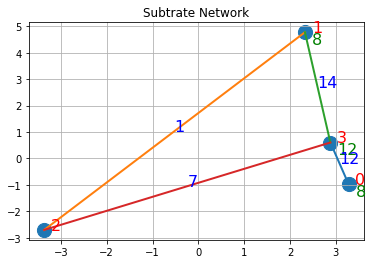

***
Optimized path from node 3 to node 2 with minimum bandwidth capacity of 2:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

Elements represent edges as noted below:
[(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)]

Time of running (in seconds):
total time = 0.007938 sec, solving ILP time = 0.004958 sec
***
Optimized path is visualized below:


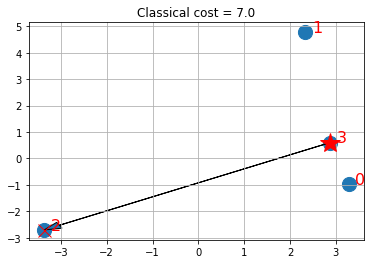

In [8]:
### TEST:
# Create graph (a.k.a. substrate network)
nt = 4
V0t = [0, 1, 2, 3]
E0t = [(0, 3), (1, 2), (1, 3), (2, 3), (3, 0), (2, 1), (3, 1), (3, 2)]
Bt = {0: 8, 1: 8, 2: 9, 3: 12}
Tt = {(0, 3): 12, (1, 2): 1, (1, 3): 14, (2, 3): 7, (3, 0): 12, (2, 1): 1, (3, 1): 14, (3, 2): 7}
SNt = (V0t, E0t, Bt, Tt)

xc_snt, yc_snt, instance_snt = initializer.generate_instance(nt, SNt[3])

print("n = " + str(nt) + "\n")

# Show substrate network
print("Subtrate network:")
print("V0 = " + str(SNt[0]))
print("E0 = " + str(SNt[1]))
print("B = " + str(SNt[2]))
print("K = " + str(SNt[3]))
print("instance_sn = \n"+str(instance_snt))
print("\n***\n")

initializer.visualize_graph(xc_snt, yc_snt, instance_snt, SNt[2], nt, "Subtrate Network")

# Define requested link and minimum bandwidth capacity
src_snt = 3
des_snt = 2
demandt = 2


# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance_snt,nt,src_snt,des_snt, demandt)

# Solve the problem in a classical fashion via CPLEX
xt = None
zt = None
try:
    xt,classical_costt = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    if classical_costt != 0:
        zt = [xt[ii] for ii in range(n**2) if ii//n != ii%n]
    else:
        zt = [0 for ii in range(n*(n-1))]
    # Print the solution
    print("***")
    print("Optimized path from node {} to node {} with minimum bandwidth capacity of {}:".format(src_snt, des_snt, demandt))
    print(zt)
    print("\nElements represent edges as noted below:")
    print([(ii//n,ii%n) for ii in range(n**2) if ii//n != ii%n])
except Exception as e:
    print("CPLEX may be missing.")
    print(e)
    
# Show passed time
print("\nTime of running (in seconds):")
print("total time = {:.6f} sec, solving ILP time = {:.6f} sec".format(classical_optimizer.get_time()[0], classical_optimizer.get_time()[1]))    

# Visualize the solution
def visualize_solution(xc, yc, x, C, n, src, des, title_str):
    
    if x is None:
        print("No solution exists.")
        return
    
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[src], yc[src], 'r*', ms=20)
    plt.plot(xc[des], yc[des], 'rx', ms=13)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()

print("***\nOptimized path is visualized below:")
visualize_solution(xc_snt, yc_snt, xt, classical_costt, nt, src_snt, des_snt, 'Classical')

### Quantum Routing

In [9]:
class QuantumOptimizer:

    def __init__(self, instance, n, src, des, demand):

        self.instance = instance
        self.n = n
        self.src = src
        self.des = des
        # index of optimization variables in instance vector
        self.z_id = [ii for ii in range(n**2) if instance[ii//n][ii%n]>= demand]
        self.m = len(self.z_id)//2  # number of available edges
        self.demand = demand  # bandwidth demand of every edge in the optimized route
        self.ttime = 0  # total solving time
        self.stime = 0  # solving QUBO time

    def binary_representation(self,x_sol=0,show_error = True):

        instance = self.instance
        n = self.n
        src = self.src
        des = self.des
        z_id = self.z_id
        m = self.m
        demand = self.demand

        A = np.sum(instance) * 10  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w = np.array([instance_vec[x] for x in range(n ** 2) if instance_vec[x] >= demand])
        
        # Some variables I will use    
        d = [[1 if x>=ii*n and x<ii*n+n else 0 for x in z_id] for ii in range(n)]
        h = [[1 if x%n==ii else 0 for x in z_id] for ii in range(n)]
        d_sd = [[d[ii][jj] for jj in range(2*m)] for ii in range(n)]
        d_sd[src] = np.zeros(2*m)
        d_sd[des] = np.zeros(2*m)        
        
        # Q defines the interactions between variables
        Q_p1 = np.dot(np.array(d).T, np.array(d))
        Q_p2 = np.dot(np.array(h).T, np.array(h))
        Q_p3 = np.dot(np.array(d_sd).T, np.array(h))
        Q = A*(Q_p1 + Q_p2 - 2*Q_p3)

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.array(d[src]) + np.array(h[des]))

        # c is the constant offset
        c = 2 * A

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except Exception as exc:
            if show_error:
                print("_QuantumOptimizer: "+str(exc))
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        
        m = self.m
        
        qp = QuadraticProgram()
        for i in range(2*m):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c

        return qp

    def solve_problem(self, qp, show_error = True):
        
        z_id = self.z_id
        n = self.n
        m = self.m
        instance = self.instance
        
        A = np.sum(instance) * 10  # A parameter of cost function
        
        # check that there is at least one optimization variable
        if m==0:
            if show_error:
                print("_QuantumOptimizer: there are no optimization variables.")
            return [], 0
        
        for ii in (0, 10598):
            algorithm_globals.random_seed = ii
            quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                               seed_simulator=algorithm_globals.random_seed,
                                               seed_transpiler=algorithm_globals.random_seed)

            vqe = QAOA(quantum_instance=quantum_instance)
            optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
            
            t0 = time.time() # start of solving
            result = optimizer.solve(qp)
            t1 = time.time() # end of solving

            # compute cost of the obtained result
            _,_,_,level = self.binary_representation(x_sol=result.x)
            
            if level < A:
                break
        
        # put the quantum result in a classical format
        r = result.x
        k = 0
        l = 0
        z_res = np.zeros(n*(n-1))
        for ii in range(n**2):
            if ii in z_id:
                z_res[l] = r[k]
                k = k+1
            if ii//n != ii%n:
                l = l+1
        
        self.stime = t1-t0
        
        return z_res.tolist(), level

In [10]:
# define a link that should be found in SN
src_vn, des_vn = VN[1][0]
src_sn, des_sn = (nm[src_vn], nm[des_vn])
demand = VN[3][(src_vn, des_vn)]
print("A path between "+str((src_sn, des_sn))+" should be found in SN with demand of "+str(demand))

# Instantiate the quantum optimizer class with parameters
quantum_optimizer = QuantumOptimizer(instance_sn, n, src_sn, des_sn, demand)

# Get binary representation
try:
    Q, g, c, binary_cost = quantum_optimizer.binary_representation()
except NameError as e:
    print("Error when getting the binary representation.")
    print(e)

qp = quantum_optimizer.construct_problem(Q, g, c)

quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

print("Path found: "+str(quantum_solution))
print("Path cost = "+str(quantum_cost))

A path between (1, 2) should be found in SN with demand of 9
_QuantumOptimizer: 'int' object is not iterable
Path found: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Path cost = 10.0


### Link Mapping Using Quantum Routing

Find sources and destinations in SN for all equivalent VN links.
Then, find an equivalent path in SN for **each edge** in VN.

In [11]:
class LinkMap:
    
    def __init__(self, SN, VN, instance_sn, node_map):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3].copy()
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
        self.n = len(self.V0)
        self.instance_sn = instance_sn.copy()
        self.node_map = node_map
    
    # Get requested links on substrate network
    def get_links(self):
        
        E1 = self.E1
        node_map = self.node_map
        
        return [(node_map[i], node_map[j]) for (i, j) in E1]
    
    def get_route_quantum(self, src, des, demand, show_results = True):
        
        instance_sn = self.instance_sn
        V0 = self.V0
        n = self.n
        
        # Instantiate the quantum optimizer class with parameters:
        quantum_optimizer = QuantumOptimizer(instance_sn, n, src, des, demand)
        
        # Get binary representation
        try:
            Q, g, c, binary_cost = quantum_optimizer.binary_representation(show_error = show_results)
        except NameError as e:
            if show_results:
                print("_LinkMap: error when getting the binary representation:")
                print(e)
        
        qp = quantum_optimizer.construct_problem(Q, g, c)
        
        quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp, show_error = show_results)

        return quantum_solution, quantum_cost
    
    def get_route_classic(self, src, des, demand, show_results = True):
        
        instance_sn = self.instance_sn
        n = self.n
        
        # Instantiate the classical optimizer class
        classical_optimizer = ClassicalOptimizer(instance_sn, n, src, des, demand)
        
        # Solve the problem in a classical fashion via CPLEX
        try:
            x, classical_cost = classical_optimizer.cplex_solution(show_results)     
            # Put the solution in the z variable
            if classical_cost != 0:
                z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
            else:
                z = [0 for ii in range(n*(n-1))]
                classsical_cost = 0
                
        except Exception as e:
            if show_results:
                print("_LinkMap: "+str(e))
            z = [0 for ii in range(n*(n-1))]
            classsical_cost = 0
            
        return z, classical_cost
    
    def update_sn(self, x, demand):
        
        K = self.K
        instance_sn = self.instance_sn
        n = self.n
        
        for ii in range(n*(n-1)):
            if x[ii]>0:
                # find src and des of the edge
                ix = ii//(n-1)
                iy = ii%(n-1)
                if iy >= ix:
                    iy = iy + 1
                
                # update K
                K[(ix, iy)] = K[(ix, iy)] - demand
                K[(iy, ix)] = K[(ix, iy)]
                
                # update instance_sn
                instance_sn[ix][iy] -= demand
                instance_sn[iy][ix] = instance_sn[ix][iy]
                
        self.K = K
        self.instance_sn = instance_sn
        
    
    def map_links(self, quantum = True, show_results = True):
        
        node_map = self.node_map
        D1 = self.D1
        E0 = self.E0
        
        links = self.get_links()
        lm = {(i, j): ([], 0) for (i, j) in links if i < j}
        rev_node_map = {node_map[i]: i for i in node_map}
        
        if len(E0)==0:
            if show_results:
                    print("_LinkMap: there are no edges in SN.")
            return lm
        
        for (i, j) in lm:
            
            demand = D1[(rev_node_map[i], rev_node_map[j])]
            
            if quantum:
                lm[(i, j)] = self.get_route_quantum(i, j, demand, show_results)
            else:
                lm[(i, j)] = self.get_route_classic(i, j, demand, show_results)
            
            # check feasibility of found route
            if not self.is_feasible(lm[(i, j)][0], lm[(i, j)][1], demand):
                if show_results:
                    print("_LinkMap: link between "+str((i, j))+" in SN is not feasible.")
                lm[(i, j)] = (lm[(i, j)][0], 0)
            
            else:
                self.update_sn(lm[(i, j)][0], demand)
                if show_results:
                    print("_LinkMap: link between "+str((i, j))+" in SN is found. [demand of "+ \
                          str((rev_node_map[i], rev_node_map[j]))+" in VN = "+str(demand)+"]")
                    print("_LinkMap: SN K has been updated. new SN k =")
                    print("_LinkMap: "+str(self.K))
        
        return lm
    
    def is_feasible(self, x, C, demand):
        
        K = self.K
        n = self.n
        instance_sn = self.instance_sn
        
        A = np.sum(instance_sn) * 10  # A parameter of cost function in quantum optimizer
        
        if C >= A or C == 0:
            return False
        
        for ii in range(n*(n-1)):
            if x[ii]>0:
                ix = ii//(n-1)
                iy = ii%(n-1)
                if iy >= ix:
                    iy = iy + 1
                
                if K[(ix, iy)] < demand:
                    return False
        return True
        
        
    def display_map(self, lm):
        
        node_map = self.node_map
        
        rev_node_map = {node_map[i]: i for i in node_map}        
        VN_edges = {(i, j): (rev_node_map[i], rev_node_map[j]) for (i, j) in lm}
        
        print("\nLink Map:")
        print("VN edge","SN edge", "cost", "path in SN", sep = '\t\t')
        print("-----------------------------------------------------------------------------")
        for (i, j) in lm:
            print(VN_edges[(i, j)], end = '\t\t')
            print('('+str(i)+", "+str(j)+')', end = '\t\t')
            print(lm[(i, j)][1], end = '\t\t')
            print(lm[(i, j)][0], end = '\n')
            
        print("-----------------------------------------------------------------------------")

In [12]:
# Map edges of virtual network to paths in substrate network
linkmap = LinkMap(SN, VN, instance_sn, nm)

links = linkmap.get_links()
print("Links between these nodes should be found in SN (Equivalents of VN edges):")
print(links)
print(' ')

lm = linkmap.map_links(quantum = True) # Caution: This line takes time to run.
linkmap.display_map(lm)

Links between these nodes should be found in SN (Equivalents of VN edges):
[(1, 2), (2, 1), (1, 0), (0, 1)]
 
_QuantumOptimizer: 'int' object is not iterable
_LinkMap: link between (1, 2) in SN is found. [demand of (0, 2) in VN = 9]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 6, (1, 2): 1, (1, 3): 14, (2, 3): 11, (1, 0): 6, (2, 1): 1, (3, 1): 14, (3, 2): 11}
_QuantumOptimizer: 'int' object is not iterable
_LinkMap: link between (0, 1) in SN is found. [demand of (1, 0) in VN = 5]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 1, (1, 2): 1, (1, 3): 14, (2, 3): 11, (1, 0): 1, (2, 1): 1, (3, 1): 14, (3, 2): 11}

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(0, 2)		(1, 2)		10.0		[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
(1, 0)		(0, 1)		6.0		[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-------------------------------------------------------------

In [13]:
def visualize_route(xc_sn, yc_sn, lm, src, des):

    if (src, des) not in lm:
        print("Error: no link between "+ str((src, des))+" is found in the link map.")
        return

    # Get the requested route
    x = lm[(src, des)][0]
    C = lm[(src, des)][1]
    
    if len(x)==0:
        print("Error: no path is defined between "+ str((src, des))+"in the link map.")
        return

    # Put the solution in a way that is compatible with the classical variables
    x_quantum = np.zeros(n ** 2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum[ii] = x[kk]
            kk +=  1  

    plt.figure()
    plt.scatter(xc_sn, yc_sn, s=200)

    for i in range(len(xc_sn)):
        plt.annotate(i, (xc_sn[i] + 0.15, yc_sn[i]), size=16, color='r')

    plt.grid()

    for ii in range(0, n ** 2):

        if x_quantum[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc_sn[ix], yc_sn[ix], xc_sn[iy] - xc_sn[ix], yc_sn[iy] - yc_sn[ix], \
                      length_includes_head=True, head_width=.25)

    plt.title('Link '+ str((src, des)) + ', Cost = ' + str(int(C * 100) / 100.))
    plt.show()
    
    if C==0:
        print("Warning: path between "+str((src, des))+" is infeasible.")


* Visualize optimized route for every link:


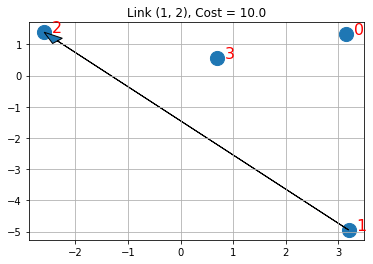

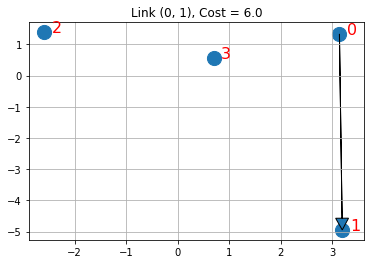

In [14]:
print("\n* Visualize optimized route for every link:")
for (i, j) in links:
    if i < j:
        visualize_route(xc_sn, yc_sn, lm, i, j)

In [15]:
# determin if a mapping has been successful, or the algorithm failed
def is_success(nm, lm, VN):

    if nm[0] == -1:
        return False

    if lm == {} and len(VN[1])>0:
        return False

    lm_v = [j for (i, j) in lm.items()]
    lm_c = [j for (i, j) in lm_v]

    if 0 in lm_c:
        return False

    return True

print(is_success(nm, lm, VN))

True


## Gathering it all in one object

Create one object with all three parts:
1. Create random graphs
2. Node mapping
3. Link mapping

In [16]:
class QVNE:
    
    def __init__(self, sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
                vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc):
        
        # basic parameters
        self.sn_min_Vs = sn_min_Vs
        self.sn_max_Vs = sn_max_Vs
        self.sn_min_cc = sn_min_cc
        self.sn_max_cc = sn_max_cc
        self.sn_min_bc = sn_min_bc
        self.sn_max_bc = sn_max_bc
        
        self.vn_min_Vs = vn_min_Vs
        self.vn_max_Vs = vn_max_Vs
        self.vn_min_cc = vn_min_cc
        self.vn_max_cc = vn_max_cc
        self.vn_min_bc = vn_min_bc
        self.vn_max_bc = vn_max_bc
        
        # problem description variables
        self.SN = ()
        self.VN = ()
        self.xc_sn = []
        self.yc_sn = []
        self.xc_vn = []
        self.yc_vn = []
        self.instance_sn = []
        self.instance_vn = []
        self.n = 0
        self.m = 0
        
        # solution variables
        self.nm = {}
        self.lm = {}
        self.links = []
    
    # Setup the problem
    def setup_problem(self, show_results = True):
        
        sn_min_Vs = self.sn_min_Vs
        sn_max_Vs = self.sn_max_Vs
        vn_min_Vs = self.vn_min_Vs
        vn_max_Vs = self.vn_max_Vs
        
        sn_min_cc = self.sn_min_cc
        sn_max_cc = self.sn_max_cc
        sn_min_bc = self.sn_min_bc
        sn_max_bc = self.sn_max_bc
        
        vn_min_cc = self.vn_min_cc
        vn_max_cc = self.vn_max_cc
        vn_min_bc = self.vn_min_bc
        vn_max_bc = self.vn_max_bc
        
        # Construct the graphs of the problem
        initializer = Initializer(sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
                                 vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc)
        (SN, VN) = initializer.generate_problem()
        
        n = len(SN[0])
        m = len(VN[0])

        xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
        xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

         # manual SN and VN alterations for testing
#         instance_sn = np.zeros((n,n))
#         SN = (SN[0], [], SN[2], {})
#         instance_vn = np.zeros((n,n))
#         VN = (VN[0], [], VN[2], {})
        
        if show_results:
            print("_QVNE.setup_problem():")
            initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
            print("n = " + str(n))
        
            initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")
            print("m = " + str(m))
        
        self.SN = SN
        self.VN = VN
        self.xc_sn = xc_sn
        self.yc_sn = yc_sn
        self.xc_vn = xc_vn
        self.yc_vn = yc_vn
        self.instance_sn = instance_sn
        self.instance_vn = instance_vn
        self.n = n
        self.m = m
    
    # Map nodes of virtual network to subtrate network (three policies are available)   
    def node_map(self, policy = 4, show_results = True):
        
        SN = self.SN
        VN = self.VN
        
        B = SN[2]
        T1 = VN[2]
        nm = {i: -1 for i in VN[0]}
        
        node_map = NodeMap(SN, VN)
        
        if policy == 1:
            nm = node_map.map_p1(show_results)
        elif policy == 2:
            nm = node_map.map_p2(show_results)
        elif policy == 3:
            nm = node_map.map_p3(show_results)
        elif policy == 4:
            nm = node_map.map_p1(show_results)
            if nm[0] == -1:
                nm = node_map.map_p2(show_results)
            if nm[0] == -1:
                nm = node_map.map_p3(show_results)     
        elif show_results:
            print("_QVNE.node_map(): policy number should be one of 1, 2, 3, 4 options.")
        
        if nm[0] == -1 and show_results:
            print("_QVNE.node_map(): node mapping was unsuccessful.")
        
        self.nm = nm
        
        if show_results:
            print("_QVNE.node_map(): map of VN->SN nodes = " + str(nm))
        
        return nm
    
    # Map edges of virtual network to paths in substrate network
    def link_map(self, quantum = True, show_results = True):
        
        SN = self.SN
        VN = self.VN
        instance_sn = self.instance_sn
        nm = self.nm
        
        if nm[0]==-1:
            if show_results:
                print("_QVNE.link_map(): node map is not acceptable.")
            return {},[]
           
        linkmap = LinkMap(SN, VN, instance_sn, nm)
        links = linkmap.get_links()
        
        if show_results:
            print("_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):")
            print("_QVNE.link_map(): "+str(links))
            print(' ')
        
        lm = linkmap.map_links(quantum = quantum, show_results = show_results) # Caution: This line takes time to run.
        
        if show_results:
            linkmap.display_map(lm)
        
        self.lm = lm
        self.links = links
        
        return lm, links
    
    # Visualize the optimized route on SN using its x vector
    def visualize_route(self, src, des):
        
        xc_sn = self.xc_sn
        yc_sn = self.yc_sn
        lm = self.lm
        n = self.n
        
        if (src, des) not in lm:
            print("_QVNE.visualize_route(): no link between "+str((src,des))+" is found in the link map.")
            return
        
        # Get the requested route
        x = lm[(src, des)][0]
        C = lm[(src, des)][1]
        
        if len(x)==0:
            print("_QVNE.visualize_route(): no path is defined between "+str((src, des))+" in the link map.")
            return
        
        # Put the solution in a way that is compatible with the classical variables
        x_quantum = np.zeros(n ** 2)
        kk = 0
        for ii in range(n ** 2):
            if ii // n != ii % n:
                x_quantum[ii] = x[kk]
                kk +=  1  
        
        plt.figure()
        plt.scatter(xc_sn, yc_sn, s=200)
        
        for i in range(len(xc_sn)):
            plt.annotate(i, (xc_sn[i] + 0.15, yc_sn[i]), size=16, color='r')

        plt.grid()

        for ii in range(0, n ** 2):

            if x_quantum[ii] > 0:
                ix = ii // n
                iy = ii % n
                plt.arrow(xc_sn[ix], yc_sn[ix], xc_sn[iy] - xc_sn[ix], yc_sn[iy] - yc_sn[ix], \
                          length_includes_head=True, head_width=.25)

        plt.title('Link '+ str((src, des)) + ', Cost = ' + str(int(C * 100) / 100.))
        plt.show()
        
        if C==0:
            print("_QVNE.visualize_route(): warning: path between "+str((src, des))+" is infeasible.")
    
    # Check if node map and link map are both feasible
    def is_success(self):
        
        nm = self.nm
        lm = self.lm
        VN = self.VN
        
        if nm[0] == -1:
            return False
        
        if lm == {} and len(VN[1])>0:
            return False
        
        lm_v = [j for (i, j) in lm.items()]
        lm_c = [j for (i, j) in lm_v]
        
        if 0 in lm_c:
            return False
        
        return True
    
    def set_links(self, links):
        
        self.links = links
        
    def set_lm(self, lm):
        
        self.lm = lm
        
    def run(self, nm_policy = 4, quantum_lm = True, show_results = True):
        
        if show_results:
            print("_QVNE.run(): seting up the problem.")
        self.setup_problem(show_results)

        if show_results:
            print("\n_QVNE.run(): mapping nodes.")
        nm = self.node_map(policy=nm_policy, show_results=show_results)
        
        if nm[0] == -1:
            if show_results:
                print("_QVNE.run(): node map is infeasible.")
                print("_QVNE.run(): success = False")
            return False

        if show_results:
            print("\n_QVNE.run(): mapping links.")
        lm, links = self.link_map(quantum = quantum_lm, show_results = show_results)
        
        if show_results:
            print("\n_QVNE.run(): visualizing optimized route for every link.")
            if len(lm)==0:
                print("_QVNE.run(): there are no required links in the link map.")
            for (i, j) in lm:
                self.visualize_route(i, j)
            
        success = self.is_success()
        
        if show_results:
            print("_QVNE.run(): success = " + str(success))
            
        return success
    
    def success_ratio(self, nm_policy = 4, shots = 3, show_summary = True, show_results = False):
        
        q_count = 0
        c_count = 0
        for ii in range(shots):
            
            np.random.seed(ii)
            q_suc = self.run(nm_policy=nm_policy, quantum_lm = True, show_results=show_results)
            np.random.seed(ii)
            c_suc = self.run(nm_policy=nm_policy, quantum_lm = False, show_results=show_results)
            
            if q_suc:
                q_count = q_count + 1
            if c_suc:
                c_count = c_count + 1
            
            if show_summary:
                print("_QVNE.success_ratio(): shot #"+str(ii)+": classsical = "+str(c_suc)+",\tquantum = "+str(q_suc))
                            
        return ((c_count * 1.)/shots), ((q_count * 1.)/shots)

# Examples

Below comes three examples of how to use the QVNE object

## Example 1:

* Seting up the problem:
_QVNE.setup_problem():


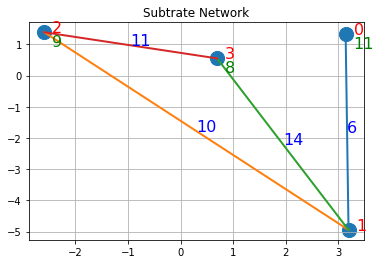

n = 4


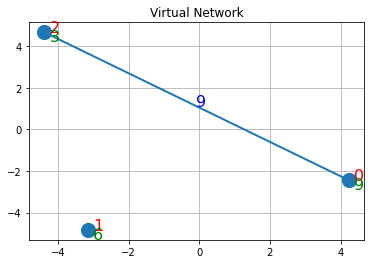

m = 3

* Node mapping:
_NodeMap: policy 1 node map: VN->SN = {0: 1, 1: 0, 2: 2}
_QVNE.node_map(): map of VN->SN nodes = {0: 1, 1: 0, 2: 2}

* Link mapping:
_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):
_QVNE.link_map(): [(1, 2), (2, 1)]
 
_QuantumOptimizer: 'int' object is not iterable
_LinkMap: link between (1, 2) in SN is found. [demand of (0, 2) in VN = 9]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 6, (1, 2): 1, (1, 3): 14, (2, 3): 11, (1, 0): 6, (2, 1): 1, (3, 1): 14, (3, 2): 11}

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(0, 2)		(1, 2)		10.0		[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-----------------------------------------------------------------------------

* Visualize optimized route for every link:


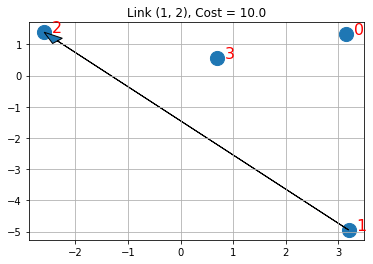

* Success = True


In [17]:
# 1) Do it all agian using the integrated class of QVNE

# Initialize the problem by defining the parameters
sn_min_Vs = 3
sn_max_Vs = 4
sn_min_cc = 8
sn_max_cc = 14
sn_min_bc = 5
sn_max_bc = 15

vn_min_Vs = 3
vn_max_Vs = 4
vn_min_cc = 1
vn_max_cc = 10
vn_min_bc = 1
vn_max_bc = 10

np.random.seed(45)

qvne = QVNE(sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
           vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc,)

print("* Seting up the problem:")
qvne.setup_problem()

print("\n* Node mapping:")
nm = qvne.node_map(policy = 1)

print("\n* Link mapping:")
lm, links = qvne.link_map(quantum = True)

print("\n* Visualize optimized route for every link:")
for (i, j) in lm:
    qvne.visualize_route(i, j)

print("* Success = "+str(qvne.is_success()))

## Example 2:

_QVNE.run(): seting up the problem.
_QVNE.setup_problem():


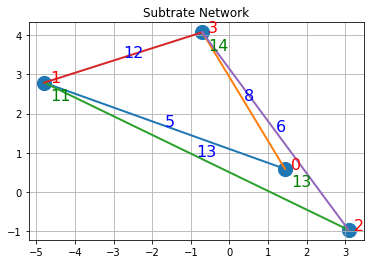

n = 4


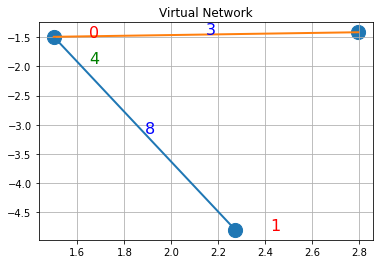

m = 3

_QVNE.run(): mapping nodes.
_NodeMap: policy 3 node map: VN->SN = {0: 1, 1: 2, 2: 0}
_QVNE.node_map(): map of VN->SN nodes = {0: 1, 1: 2, 2: 0}

_QVNE.run(): mapping links.
_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):
_QVNE.link_map(): [(1, 2), (1, 0), (2, 1), (0, 1)]
 
_QuantumOptimizer: 'int' object is not iterable
_LinkMap: link between (1, 2) in SN is found. [demand of (0, 1) in VN = 8]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 5, (0, 3): 8, (1, 2): 5, (1, 3): 12, (2, 3): 6, (1, 0): 5, (3, 0): 8, (2, 1): 5, (3, 1): 12, (3, 2): 6}
_QuantumOptimizer: 'int' object is not iterable
_LinkMap: link between (0, 1) in SN is found. [demand of (2, 0) in VN = 3]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 2, (0, 3): 8, (1, 2): 5, (1, 3): 12, (2, 3): 6, (1, 0): 2, (3, 0): 8, (2, 1): 5, (3, 1): 12, (3, 2): 6}

Link Map:
VN edge		SN edge		cost		path in SN
------------------------------------------------

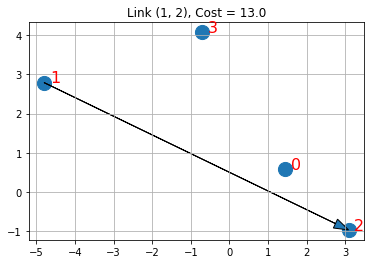

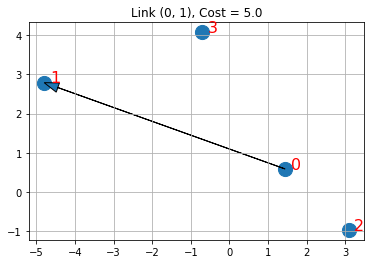

_QVNE.run(): success = True


True

In [18]:
# 2) Do it all agian using run() method of class QVNE

# Initialize the problem by defining the parameters
sn_min_Vs = 3
sn_max_Vs = 4
sn_min_cc = 8
sn_max_cc = 14
sn_min_bc = 5
sn_max_bc = 15

vn_min_Vs = 3
vn_max_Vs = 4
vn_min_cc = 1
vn_max_cc = 10
vn_min_bc = 1
vn_max_bc = 10

np.random.seed(55)

qvne = QVNE(sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
           vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc,)
qvne.run(nm_policy = 3, quantum_lm = True, show_results = True)

## Example 3:

In [19]:
# 3) Get success ratio of algorithm by running it multiple times

# Initialize the problem by defining the parameters
sn_min_Vs = 3
sn_max_Vs = 4
sn_min_cc = 8
sn_max_cc = 14
sn_min_bc = 5
sn_max_bc = 15

vn_min_Vs = 3
vn_max_Vs = 4
vn_min_cc = 1
vn_max_cc = 10
vn_min_bc = 1
vn_max_bc = 10

np.random.seed(45)

shots = 10
nm_policy = 4

qvne = QVNE(sn_min_Vs, sn_max_Vs, sn_min_cc, sn_max_cc, sn_min_bc, sn_max_bc, \
           vn_min_Vs, vn_max_Vs, vn_min_cc, vn_max_cc, vn_min_bc, vn_max_bc,)
csr, qsr = qvne.success_ratio(nm_policy=nm_policy, shots=shots, show_summary = True, show_results = False)

print("After " + str(shots) + " runs,\nclassical success ratio = " + str(csr))
print("quantum success ratio = "+str(qsr))
print("-> relative success ratio = "+str(qsr/csr))

_QVNE.success_ratio(): shot #0: classsical = False,	quantum = False
_QVNE.success_ratio(): shot #1: classsical = True,	quantum = True
_QVNE.success_ratio(): shot #2: classsical = False,	quantum = False
_QVNE.success_ratio(): shot #3: classsical = False,	quantum = False
_QVNE.success_ratio(): shot #4: classsical = False,	quantum = False
_QVNE.success_ratio(): shot #5: classsical = True,	quantum = True
_QVNE.success_ratio(): shot #6: classsical = False,	quantum = False
_QVNE.success_ratio(): shot #7: classsical = True,	quantum = True
_QVNE.success_ratio(): shot #8: classsical = True,	quantum = True
_QVNE.success_ratio(): shot #9: classsical = False,	quantum = False
After 10 runs,
classical success ratio = 0.4
quantum success ratio = 0.4
-> relative success ratio = 1.0


# End of Notebook
***